# Load in Libraries

In [1]:
import numpy as np
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt
import math
import copy

from landlab.components import OverlandFlow
from landlab.io.esri_ascii import read_esri_ascii
from landlab.grid.mappers import map_max_of_node_links_to_node
from landlab.plot import imshow

# Set up RasterModelGrid

No vegetation scenario

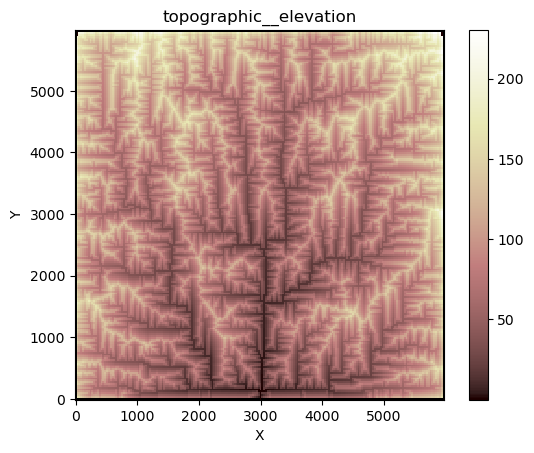

In [2]:
#read in artificially generated raster
grid, z = read_esri_ascii("square-test-basin.asc", name="topographic__elevation")

#close all boundaries
grid.set_closed_boundaries_at_grid_edges(True, True, True, True)

#open the outlet 
#This DEM was generated using Landlab and the outlet node ID was known
my_outlet_node = 100
grid.status_at_node[my_outlet_node] = grid.BC_NODE_IS_FIXED_VALUE

#plot elevation
figure('elevation')
imshow.imshow_grid_at_node(grid, "topographic__elevation")

# Adding Fields to Grid

In [3]:
#add surface water depth (1 m everywhere)
grid.add_ones("surface_water__depth", at = "node", clobber = True)

#now add rouughness
grid.add_zeros("rough",  at = "node", clobber=True)

#map roughness to link
r = grid.map_mean_of_link_nodes_to_link("rough")

#add to grid
grid.add_field("mannings_n", r, at = "link", clobber=True)

#check that they are there
grid.at_link.keys()

['mannings_n']

# Define function for constant roughness

In [4]:
#hydrograph function for constant mannings n
def constantM(n):
    
    #initializing list
    hydrograph_time = []
    discharge_at_outlet = []

    #setting up run time params
    run_time = 500
    elapsed_time = 0.0
    
    #read in artificially generated raster
    grid, z = read_esri_ascii("square-test-basin.asc", name="topographic__elevation")

    #close all boundaries
    grid.set_closed_boundaries_at_grid_edges(True, True, True, True)

    #open the outlet 
    #This DEM was generated using Landlab and the outlet node ID was known
    my_outlet_node = 100
    grid.status_at_node[my_outlet_node] = grid.BC_NODE_IS_FIXED_VALUE
 
    #add surface water depth (1 m everywhere)
    grid.add_ones("surface_water__depth", at = "node", clobber = True)

    #now add rouughness
    grid.add_zeros("rough",  at = "node", clobber=True)

    #map roughness to link
    r = grid.map_mean_of_link_nodes_to_link("rough")

    #add to grid
    grid.add_field("mannings_n", r, at = "link", clobber=True)
    
    #initializing Overland flow with a constant n
    of = OverlandFlow(grid,
                      alpha = 0.7,
                      mannings_n = n, 
                      rainfall_intensity=2*(10**-6), #convert mm/hr to m/s
                      steep_slopes=True)
        
    #running the model
    while elapsed_time <= run_time:
        of.dt = of.calc_time_step() # Adaptive time step

        
        of.overland_flow() #run model
        
        #get discharge at outlet link
        outlet = grid.at_link['surface_water__discharge'][299]
        
        hydrograph_time.append(elapsed_time / 3600.) # convert seconds to hours
        discharge_at_outlet.append(np.abs(outlet) * grid.dx) # append discharge in m^3/s
        
        elapsed_time += of.dt #update elapsed time
        
    return grid, hydrograph_time, discharge_at_outlet, elapsed_time # maybe we don't need to see the elapsed time

# Baptist Formula Class

In [5]:
#class for calc roughness and convert to mannings n
class FlowResistance():
    def Baptist_2007(self, mannings_n, drag_coef, veg_den, veg_diam, veg_height, gravity, van_karman, water_depth):
        bed_roughness = (water_depth**(1/6))/mannings_n
        #The baptist equation 
        Cr1=1/np.sqrt((1/(bed_roughness**2))+drag_coef*veg_den*veg_diam*veg_height/(2*gravity)) + (np.sqrt(gravity)/van_karman)*np.log(water_depth/veg_height)
        Cr2=1/np.sqrt((1/(bed_roughness**2))+drag_coef*veg_den*veg_diam*veg_height/(2*gravity)) 
        if (veg_height>=water_depth).all():
            return Cr2
        else:
            return Cr1
        
    def chezy_to_manning(self,water_depth,Chezy):
        #The actual relationship
        n=water_depth**(1/6)/Chezy
        return n

# Function for roughness that varies with water depth

In [21]:
#using variable mannings n value
def newOverlandFlow(den, diam, height, mannings_n):
    
        
    #initializing list
    hydrograph_time = []
    discharge_at_outlet = []
    outlet_m = []
    
    #set up time steps
    run_time = 100
    elapsed_time = 0.0
    
    #read in artificially generated raster
    grid, z = read_esri_ascii("square-test-basin.asc", name="topographic__elevation")

    #close all boundaries
    grid.set_closed_boundaries_at_grid_edges(True, True, True, True)

    #open the outlet 
    #This DEM was generated using Landlab and the outlet node ID was known
    my_outlet_node = 100
    grid.status_at_node[my_outlet_node] = grid.BC_NODE_IS_FIXED_VALUE
 
    #add surface water depth (1 m everywhere)
    grid.add_ones("surface_water__depth", at = "node", clobber = True)

    #now add rouughness
    grid.add_zeros("rough",  at = "node", clobber=True)

    #map roughness to link
    r = grid.map_mean_of_link_nodes_to_link("rough")

    #add to grid
    grid.add_field("mannings_n", r, at = "link", clobber=True)
    
    #initialize model
    of = OverlandFlow(grid, 
                      alpha = 0.7,
                      mannings_n = "mannings_n",
                      rainfall_intensity=2*(10**-6), 
                      steep_slopes=True)
    
    #start loop
    while elapsed_time <= run_time:
        new_manning = []
        for depth in grid.at_link["surface_water__depth"]:
            #call flow resistance class
            flow_resistance = FlowResistance()
            #calculate Chezy's coefficient
            cr = flow_resistance.Baptist_2007(mannings_n=mannings_n, 
                                              drag_coef=1.0, 
                                              veg_den=den, 
                                              veg_diam=diam, 
                                              veg_height=height, 
                                              gravity=9.81, 
                                              van_karman=0.41, 
                                              water_depth=depth)
        
            #convert new chezy to manning
            n=flow_resistance.chezy_to_manning(depth,cr)
            new_manning.append(n)
        
    
        #add new mannings to links
        grid.add_field("mannings_n", new_manning, at = "link", clobber=True)
        of.dt = of.calc_time_step()     # Adaptive time step
        of.overland_flow() #run the model
        
        #get discharge at outlet link
        outlet = grid.at_link['surface_water__discharge'][299]
        m_at_outlet = grid.at_link["mannings_n"][299]
        
        hydrograph_time.append(elapsed_time / 3600.) # convert seconds to hours
        discharge_at_outlet.append(np.abs(outlet) * grid.dx) # append discharge in m^3/s
        outlet_m.append(np.abs(m_at_outlet) * grid.dx)
                                
        elapsed_time += of.dt #update time step
    
    return grid, hydrograph_time, discharge_at_outlet, outlet_m


In [22]:
#running model for grass
time_constant_grass, discharge_constant_grass = constantM(0.02)[1:3] 


time_variable_grass, discharge_variable_grass, manning_outlet_grass = newOverlandFlow(den = 4500, 
                                                                diam = 0.003,                                                                  height = 0.15, 
                                                                mannings_n = 0.02)[1:4] 


#running model for shrubs
time_constant_shrub, discharge_constant_shrub = constantM(0.1)[1:3] 


time_variable_shrub, discharge_variable_shrub, manning_outlet_shrub = newOverlandFlow(den = 500, 
                                                                 diam = 0.01, 
                                                                 height = 0.5, 
                                                                mannings_n = 0.1)[1:4] 


#running model for tree
time_constant_tree, discharge_constant_tree = constantM(0.1)[1:3] 


time_variable_tree, discharge_variable_tree, manning_outlet_tree = newOverlandFlow(den = 1, 
                                                               diam = 0.7, 
                                                               height = 10, 
                                                               mannings_n = 0.1)[1:4] 



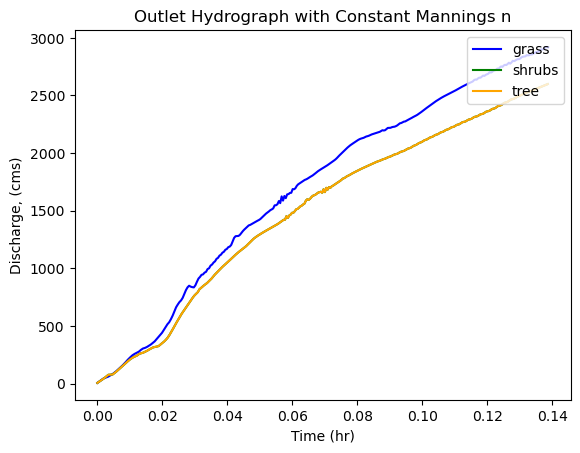

In [8]:
#plot hydrograph at outlet link
plt.plot(time_constant_grass, discharge_constant_grass, label = "grass", color = "blue")
plt.plot(time_constant_shrub, discharge_constant_shrub, label = "shrubs", color = "green")
plt.plot(time_constant_tree, discharge_constant_tree, label = "tree", color = "orange")
plt.legend(loc = "upper right")
plt.xlabel('Time (hr)')
plt.ylabel('Discharge, (cms)')
plt.title('Outlet Hydrograph with Constant Mannings n')
plt.show()

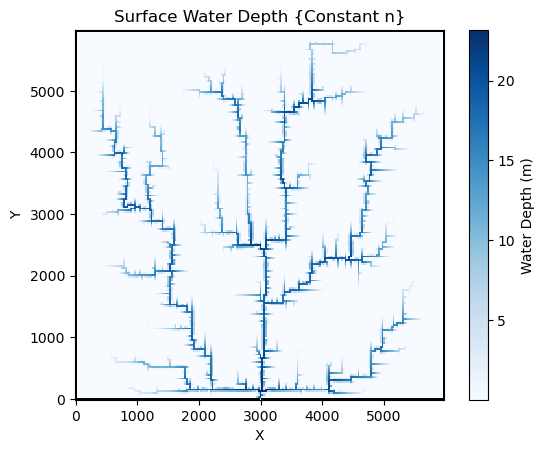

In [10]:
#run function and return grid
grass_constant_m = constantM(n = 0.02)[0]

#figure showing water depth on grid
figure('water depth')
imshow.imshow_grid(grass_constant_m, "surface_water__depth", 
                   cmap = 'Blues', 
                   plot_name = 'Surface Water Depth {Constant n}', 
                   var_name = 'Water Depth (m)')

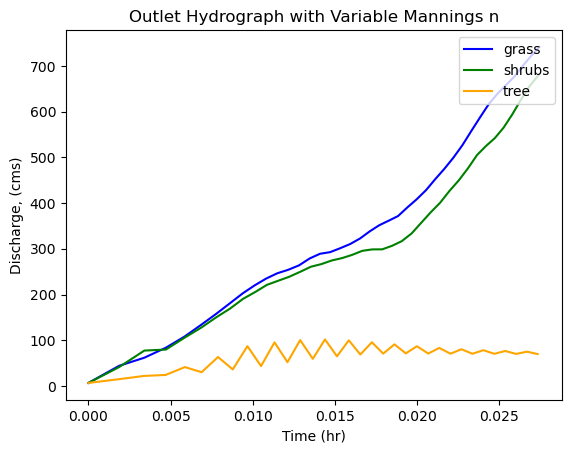

In [11]:
#plot hydrograph at outlet link
plt.plot(time_variable_grass, discharge_variable_grass, label = "grass", color = "blue")
plt.plot(time_variable_shrub, discharge_variable_shrub, label = "shrubs", color = "green")
plt.plot(time_variable_tree, discharge_variable_tree, label = "tree", color = "orange")
plt.legend(loc = "upper right")
plt.xlabel('Time (hr)')
plt.ylabel('Discharge, (cms)')
plt.title('Outlet Hydrograph with Variable Mannings n')
plt.show()

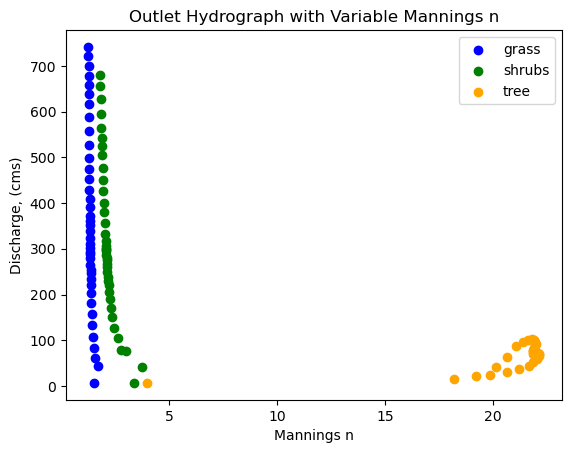

In [23]:
#plot hydrograph at outlet link
plt.scatter(manning_outlet_grass, discharge_variable_grass, label = "grass", color = "blue")
plt.scatter(manning_outlet_shrub, discharge_variable_shrub, label = "shrubs", color = "green")
plt.scatter(manning_outlet_tree, discharge_variable_tree, label = "tree", color = "orange")
plt.legend(loc = "upper right")
plt.xlabel('Mannings n')
plt.ylabel('Discharge, (cms)')
plt.title('Outlet Hydrograph with Variable Mannings n')
plt.show()

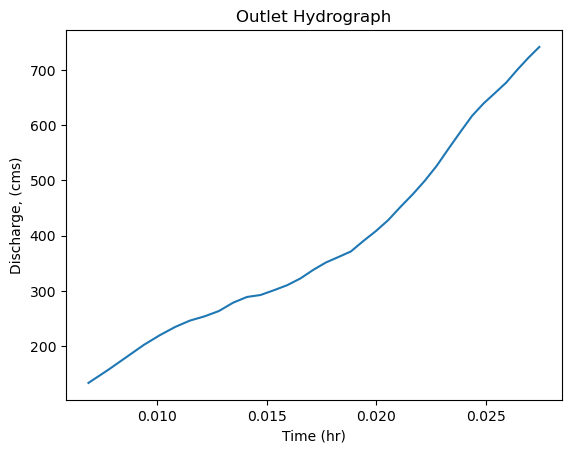

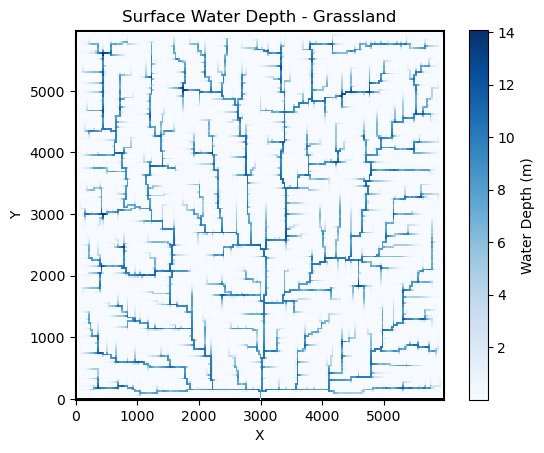

In [12]:
time, discharge = newOverlandFlow(den = 4500, diam = 0.003, height = 0.15, mannings_n = 0.02)[1:3] # https://landlab.readthedocs.io/en/master/user_guide/overland_flow_user_guide.html
plt.plot(time[5:], discharge[5:])
plt.xlabel('Time (hr)')
plt.ylabel('Discharge, (cms)')
plt.title('Outlet Hydrograph')
plt.show()


# calculate the roughness for different vegetation

# Veg 1 - grassland
# varrying n
#print(newOverlandFlow(den = 10000, diam = 0.003, height = 0.15, mannings_n = 0.02)[1])
grass_varying_n = newOverlandFlow(den = 4500, diam = 0.003, height = 0.15, mannings_n = 0.02)[0]
#figure('water depth')
imshow.imshow_grid(grass_varying_n,  "surface_water__depth", 
                           cmap = 'Blues', 
                           plot_name = 'Surface Water Depth - Grassland', # figure out how to change title
                           var_name = 'Water Depth (m)',
                           at = 'node')
#print(len(new_manning))
#print(grid.number_of_links)
#print(elapsed_time)

In [20]:
manning_outlet_grass

[6.643069042185993,
 43.999395483306365,
 61.797272725478066,
 83.589564201582121,
 107.92351583449921,
 133.60321516680003,
 157.57104427511763,
 180.89760265358197,
 202.5949951745651,
 220.10825038118708,
 234.91132806152461,
 246.38606924036213,
 253.97522024333006,
 263.68087909099751,
 278.83005531084729,
 289.09865911358338,
 292.60995874722181,
 301.25559871725983,
 310.41923464669151,
 322.55702803344332,
 338.18625578948826,
 351.52772175315744,
 361.35519845497879,
 371.51182591414971,
 390.57532857870319,
 408.37339408817269,
 428.31548392532858,
 452.30557289512598,
 474.85838759279159,
 499.31487428881189,
 526.56400646018153,
 557.70963740553702,
 587.82312486421029,
 616.788654120351,
 639.13902812455092,
 657.87164952252397,
 676.74606861036864,
 700.14125776078458,
 721.7979532237963,
 741.4263873877419]